## 1. Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2. Input values of the model

In [2]:

#input values, ship related (values of M9)

L = 135
B = 11.4
T = 3.5
P_installed = 2200 #kW 
h1 = 10
V_0 = np.linspace(0.1, 8, 200)
V_0_km = V_0 * 3.6
#Fixed input values
C_B = 0.85      #block coefficient 
viscosity = 1*10**(-6) #kinematic viscosity
rho = 1000
g = 9.81
x = 2 #number of screws
eta_0 = 0.6     #open water eff
eta_r = 0.98     #relative rotative eff
eta_t = 0.98     #transmission eff
eta_g = 0.96     #gearing eff
c_stern = 0
one_k2 = 2.5 #appendage resistance factor


In [3]:
#Ship related values, calculated from above input values

C_M = 1.006 - 0.0056 * C_B **(-3.56)       #midshipcoefficient
C_wp = (1+2 * C_B)/3                       #waterplane coefficient
C_p = C_B / C_M                            #prismatic coefficient

delta = C_B * L * B * T                    #water displacement

lcb = -13.5 + 19.4 * C_p                   #longitudinal position of the centre of buoyancy as % of L
L_R = L * (1 - C_p + (0.06 * C_p * lcb)/(4 * C_p -1))   #Length of the run

A_T = 0.2 * B * T     #area immersed transom

#Total wet surface area (S_T), wet area of appendages (S_APP) and wet area of flat bottom (S_B)
S_T = L*(2*T + B) * np.sqrt(C_M) * (0.453 + 0.4425 * C_B - 0.2862* C_M - 0.003467 * (B/T) + 0.3696 * C_wp) #+ 2.38 * (A_BT / C_B)
S_APP = 0.05 * S_T
S_B = L * B

#Screw diameter
D_s = 0.7 * T

## 3. Method to calculate different resistance components a ship experiences

Method based on the division of Holtrop & Mennen, with some adjustments made in order to incorporate the shallow water effects

### A) Karpov velocity correction for limited water depths

In [4]:
############ Additional wave making resistance - Karpov #############
R_e = V_0 * L / viscosity

def karpov(h, F_n):
    
    #The Froude number used in the Karpov method is the depth related froude number F_nh
    
    #The different alpha** curves are determined with a sixth power polynomial approximation in Excel
    #A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve
    
    if F_n <= 0.4:
        
        if 0 <= h/T < 1.75:
            alpha_xx = (-4*10**(-12)) * F_n**3 - 0.2143 * F_n**2 -0.0643 * F_n + 0.9997
        elif 1.75 <= h/T < 2.25:
            alpha_xx = -0.8333 * F_n**3 + 0.25 * F_n**2 - 0.0167 * F_n + 1
        elif 2.25 <= h/T < 2.75:
            alpha_xx = -1.25 * F_n**4 + 0.5833 * F_n**3 - 0.0375 * F_n**2 - 0.0108 * F_n + 1
        elif h/T >= 2.75:
            alpha_xx = 1
    
    elif F_n > 0.4:
        if 0 <= h/T < 1.75:
            alpha_xx = -0.9274 * F_n**6 + 9.5953 * F_n**5 - 37.197 * F_n**4 + 69.666 * F_n**3 - 65.391 * F_n**2 + 28.025 * F_n - 3.4143
        elif 1.75 <= h/T < 2.25:
            alpha_xx = 2.2152 * F_n**6 - 11.852 * F_n**5 + 21.499 * F_n**4 - 12.174 * F_n**3 - 4.7873 * F_n**2 + 5.8662 * F_n - 0.2652
        elif 2.25 <= h/T < 2.75:
            alpha_xx = 1.2205 * F_n**6 - 5.4999 * F_n**5 + 5.7966 * F_n**4 + 6.6491 * F_n**3 - 16.123 * F_n**2 + 9.2016 * F_n - 0.6342
        elif 2.75 <= h/T < 3.25:
            alpha_xx = -0.4085 * F_n**6 + 4.534 * F_n**5 - 18.443 * F_n**4 + 35.744 * F_n**3 - 34.381 * F_n**2 + 15.042 * F_n - 1.3807
        elif 3.25 <= h/T < 3.75:
            alpha_xx = 0.4078 * F_n **6 - 0.919 * F_n**5 - 3.8292 * F_n**4 + 15.738 * F_n**3 - 19.766 * F_n**2 + 9.7466 * F_n - 0.6409
        elif 3.75 <= h/T < 4.5:
            alpha_xx = 0.3067 * F_n**6 - 0.3404 * F_n**5 - 5.0511 * F_n**4 + 16.892 * F_n**3 - 20.265 * F_n**2 + 9.9002 * F_n - 0.6712
        elif 4.5 <= h/T < 5.5:
            alpha_xx = 0.3212 * F_n**6 - 0.3559 * F_n**5 - 5.1056 * F_n**4 + 16.926 * F_n**3 - 20.253 * F_n**2 + 10.013 * F_n - 0.7196
        elif 5.5 <= h/T < 6.5:
            alpha_xx = 0.9252 * F_n**6 - 4.2574 * F_n**5 + 5.0363 * F_n **4 + 3.3282 * F_n**3 - 10.367 * F_n**2 + 6.3993 * F_n - 0.2074
        elif 6.5 <= h/T < 7.5:
            alpha_xx = 0.8442 * F_n**6 - 4.0261 * F_n**5 + 5.313 * F_n **4 + 1.6442 * F_n**3 - 8.1848 * F_n**2 + 5.3209 * F_n - 0.0267
        elif 7.5 <= h/T < 8.5:
            alpha_xx = 0.1211 * F_n**6 + 0.628 * F_n**5 - 6.5106 * F_n**4 + 16.7 * F_n**3 - 18.267 * F_n**2 + 8.7077 * F_n - 0.4745
        
                
        elif 8.5 <= h/T < 9.5:
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.4069 * F_n**6 + 47.308 * F_n**5 - 141.93 * F_n**4 + 220.23 * F_n**3 - 185.05 * F_n**2 + 79.25 * F_n - 12.484
        elif h/T >= 9.5: 
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.0727 * F_n**6 + 44.97 * F_n**5 - 135.21 * F_n**4 + 210.13 * F_n**3 - 176.72 * F_n**2 + 75.728 * F_n - 11.893
    
    return alpha_xx


### B) Frictional resistance and appendage resistance (dependend on V0 and h) 

In [5]:
#### Method of Zeng(2019) incorporating the shallow water effect in the frictional resistance term #######

def frictional_resistance(h):
    R_e = V_0 * L / viscosity
    D = h - T #distance from bottom ship to the bottom of the fairway

    Cf_0 = 0.075 / ((np.log10(R_e)-2)**2)
    
    Cf_proposed = (0.08169/((np.log10(R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(R_e) - 4.393)) * (D/L)**(-1.083))

    a = 0.042612 * np.log10(R_e) + 0.56725
    
    Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762)**a)

    if h/T <= 4:
        V_B = 0.4277 * V_0 * np.exp((h / T)**(-0.07625))
    else:
        V_B = V_0

    C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0)**2

    R_f = (C_f * 0.5 * rho * (V_0**2) * S_T) / 1000 #kN
    
    R_APP = (0.5 * rho * (V_0**2) * S_APP * one_k2 * C_f) / 1000 #kN
    
    return R_f, R_APP, V_B, C_f, Cf_0

### C) Viscous resistance 

In [6]:
#Section 2.2.2 Viscous resistance

c_14 = 1 + 0.0011 * c_stern
one_k1 = 0.93+0.487 * c_14 * ((B/L)**1.068) * ((T/L)**0.461) * ((L/L_R)**0.122) * (((L**3)/delta)**0.365) * ((1 - C_p)**(-0.604))

### D) Wave resistance  (dependend on V2)

In [7]:
# #This is Holtrop & Mennen's Rw
def wave_resistance(V_2):
    F_nL = V_2 / np.sqrt(g*L) #Froude number

#parameter c_7 is determined by the B/L ratio
    if B/L < 0.11:
        c_7 = 0.229577 * (B/L)**0.33333
    elif B/L > 0.25:
        c_7 = 0.5 - 0.0625 * (L/B)
    else: 
        c_7 = B/L

#parameter c_16 depends on C_p
    if C_p < 0.8:
        c_16 = 8.07981 * C_p - 13.8673 * (C_p**2) + 6.984388 * (C_p**3)
    else:
        c_16 = 1.73014 - 0.7067 * C_p

#parameter c_15 depoends on the ratio L^3 / delta
    if (L**3) / delta < 512:
        c_15 = -1.69385
    elif (L**3) / delta > 1727:
        c_15 = 0
    else:
        c_15 = -1.69385 + (L / (delta**(1/3)) - 8) / 2.36
#half angle of entrance in degrees
    i_E = 1 + 89 * np.exp(-((L/B)**0.80856) * ((1 - C_wp)**0.30484) * ((1 - C_p - 0.0225 * lcb)**0.6367) * ((L_R / B)**0.34574) * ((100 * delta / (L**3))**0.16302))

    c_1 = 2223105 * (c_7**3.78613) * ((T/B)**1.07961) * (90 - i_E)**(-1.37165) 
    c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
    c_5 = 1 - (0.8 * A_T) / (B * T * C_M) #influence of the transom stern on the wave resistance
    if L/B < 12:
         lmbda = 1.446 * C_p - 0.03 * (L/B)
    else: 
         lmbda = 1.446 * C_p - 0.36

    m_1 = 0.0140407 * (L / T) - 1.75254 * ((delta)**(1/3) / L) - 4.79323 * (B / L) - c_16  
    m_2=c_15 * (C_p**2) *np.exp((-0.1)* (F_nL**(-2))) 
    R_W = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_nL**(-0.9)) + m_2 * np.cos(lmbda * (F_nL**(-2))))/1000 

    return R_W


In [8]:
# #Section 2.2.4 Wave resistance

# def wave_resistance(V_2):

# #This method is based on literature of Sarris (Naval Ship Propulsion and Electric Power Systems Selection for
# #Optimal Fuel Consumption) (2003) applying Holtrop and Mennen (pag 26)

#     F_n = V_2 / np.sqrt(g*L) #Froude number


#     #parameter c_7 is determined by the B/L ratio
#     if B/L < 0.11:
#         c_7 = 0.229577 * (B/L)**0.33333
#     elif B/L > 0.25:
#         c_7 = 0.5 - 0.0625 * (L/B)
#     else: 
#         c_7 = B/L

#     #half angle of entrance in degrees
#     i_E = 1 + 89 * np.exp(-((L/B)**0.80856) * ((1 - C_wp)**0.30484) * ((1 - C_p - 0.0225 * lcb)**0.6367) * ((L_R / B)**0.34574) * ((100 * delta / (L**3))**0.16302))

#     c_1 = 2223105 * (c_7**3.78613) * ((T/B)**1.07961) * (90 - i_E)**(-1.37165) 
#     c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
#     c_5 = 1 - (0.8 * A_T) / (B * T * C_M) #influence of the transom stern on the wave resistance

#     #parameter c_15 depoends on the ratio L^3 / delta
#     if (L**3) / delta < 512:
#         c_15 = -1.69385
#     elif (L**3) / delta > 1727:
#         c_15 = 0
#     else:
#         c_15 = -1.69385 + (L / (delta**(1/3)) - 8) / 2.36

#     #parameter c_16 depends on C_p
#     if C_p < 0.8:
#         c_16 = 8.07981 * C_p - 13.8673 * (C_p**2) + 6.984388 * (C_p**3)
#     else:
#         c_16 = 1.73014 - 0.7067 * C_p

#     m_1 = 0.0140407 * (L / T) - 1.75254 * ((delta)**(1/3) / L) - 4.79323 * (B / L) - c_16

#     m_4 = 0.4 * c_15 * np.exp(-0.034 * (F_n**(-3.29)))    

#     if L/B < 12:
#         lmbda = 1.446 * C_p - 0.03 * (L/B)
#     else: 
#         lmbda = 1.446 * C_p - 0.36

#     #parameters needed for RW_2
#     c_17 = 6919.3 * (C_M**(-1.3346)) * ((delta/ (L**3))**2.00977) * ((L/B - 2)**1.40692)
#     m_3 = -7.2035 * ((B / L)**0.326869) * ((T/B)**0.605375)


#     ######### When Fn < 0.4
#     RW_1 = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2)))) 

#     ######## When Fn > 0.5
#     RW_2 = c_17 * c_2 * c_5 * delta * rho * g * np.exp(m_3 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2))))
    
#     if F_n < 0.4:
#         R_W = RW_1 / 1000 #kN
#     elif F_n > 0.55:
#         R_W = RW_2 / 1000 #kN
#     else:
#         R_W = (RW_1 + ((10 * F_n - 4) * (RW_2 - RW_1)) / 1.5) / 1000 #kN
        
#     return R_W

### E) Residual resistance terms 

In [9]:
#Section 2.2.5 Residual resistance terms


#Resistance due to immersed transom
def resistance_transom(V_2):
    F_nt = V_2 / np.sqrt(2 * g * A_T / (B + B * C_wp))

    c_6 = 0.2 * (1 - 0.2 * F_nt)

    R_TR = (0.5 * rho * (V_2**2) * A_T * c_6) / 1000 #kN
    
    return R_TR

#Model-ship correlation resistance
def resistance_model_correlation(V_2):
    if T / L < 0.04:
        c_4 = T / L
    else:
        c_4 = 0.04
    c_2 = 1
    
    C_A = 0.006 * (L + 100)**(-0.16) - 0.00205 + 0.003 * np.sqrt(L / 7.5) * (C_B**4) * c_2 * (0.04 - c_4)

    #C_A = (1.8 + 260/L) * 0.0001 #Holtrop 1977

    ####### Holtrop and Mennen in the document of Sarris, 2003 #######
    R_A = (0.5 * rho * (V_2**2) * S_T * C_A) / 1000 #kW
    
    return R_A

### add values into functions

In [10]:
# depth Froude number
F_nh1 = V_0 / np.sqrt(g * h1)

#The corrected velocity V2 (Karpov) is going to be applied in all resistance components of the Holtrop and Mennen method
#Except for frictional resistance

V2_1 = np.zeros(len(F_nh1))

for i in range(len(F_nh1)):
    V2_1[i] = V_0[i] / karpov(h1, F_nh1.item(i))


In [11]:
R_f_1 = frictional_resistance(h1)[0]
R_APP_1 = frictional_resistance(h1)[1]

In [12]:
R_W_1 = np.zeros(len(V_0))
for i in range(len(V_0)):
    R_W_1[i] = wave_resistance(V2_1.item(i))


In [13]:
R_TR_1 = np.zeros(len(V_0))
for i in range(len(V_0)):
    R_TR_1[i] = resistance_transom(V2_1.item(i))

In [14]:
R_A_1 = np.zeros(len(V_0))
for i in range(len(V_0)):
    R_A_1[i] = resistance_model_correlation(V2_1.item(i))

## 5. Total resistance of a single ship, for different water depth, as a function of V0

In [15]:
#Section 2.2 Resistance

#Total resistance

#For water depth h1 = 10 m
R_tot1 = R_f_1 * one_k1 + R_APP_1 + R_W_1 + R_TR_1 + R_A_1
print(R_W_1)

[4.26296543e-102 1.22223696e-074 7.12092225e-059 1.36571697e-048
 2.48861887e-041 6.43639813e-036 1.01517040e-031 2.30065989e-028
 1.28252870e-025 2.50750049e-023 2.19397382e-021 1.02149446e-019
 2.87196330e-018 5.35962176e-017 7.13587926e-016 7.16911549e-015
 5.68058656e-014 3.67779538e-013 2.00207159e-012 9.38084171e-012
 3.85727722e-011 1.41451094e-010 4.68932619e-010 1.42161890e-009
 3.97996455e-009 1.03764560e-008 2.53771680e-008 5.85861559e-008
 1.28377280e-007 2.68293913e-007 5.37032154e-007 1.03342701e-006
 1.91817815e-006 3.44436331e-006 5.99907233e-006 1.01587322e-005
 1.67608642e-005 2.69951016e-005 4.25162902e-005 6.55823867e-005
 9.92196614e-005 1.47417406e-004 2.15353953e-004 3.09655347e-004
 4.38687477e-004 6.12881913e-004 8.45095094e-004 1.15099992e-003
 1.54950823e-003 2.06322204e-003 2.71891098e-003 3.54801284e-003
 4.58715377e-003 5.87868435e-003 7.47122746e-003 9.42023370e-003
 1.17885400e-002 1.46469273e-002 1.80746721e-002 2.21600888e-002
 2.70010579e-002 3.270553

### Resistance plot

#### Plotting the different resistance components for h = 10, as a function of V0

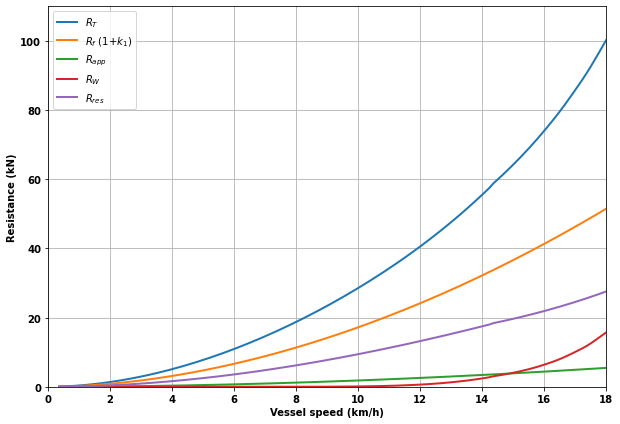

In [16]:
#Vessel speed versus resistance
plt.figure(figsize=(10,7))
plt.plot(V_0_km, R_tot1, linewidth = 2.0)
plt.plot(V_0_km, one_k1*R_f_1, linewidth = 2.0)
plt.plot(V_0_km, R_APP_1, linewidth = 2.0)
plt.plot(V_0_km, R_W_1, linewidth = 2.0)
plt.plot(V_0_km, R_TR_1 + R_A_1, linewidth = 2.0)
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 110)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('resistance components.pdf', dpi=600, format='pdf') 
#plt.title('Vessel speed versus resistance (L = 135 m, B = 11.4 m, T = 3.5 m, h = 10 m)')